In [1]:
import numpy as np
import pandas as pd
import re
import unicodedata
import re
import nltk
import nltk.sentiment
import matplotlib.pyplot as plt
import seaborn as sns

import acquire
import prepare
import wrangle

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from random import sample
from wordcloud import WordCloud


In [2]:
# for purposes of initial planning, let's go with utterances.csv for now
df1 = pd.read_csv('archive/utterances.csv')
df2 = pd.read_csv('archive/utterances-2sp.csv')

In [3]:
# check columns and shape
df1.columns, df2.columns, df1.shape, df2.shape

(Index(['episode', 'episode_order', 'speaker', 'utterance'], dtype='object'),
 Index(['episode', 'episode_order', 'turn_order', 'speaker_order', 'host_id',
        'is_host', 'utterance'],
       dtype='object'),
 (3199858, 4),
 (1240112, 7))

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199858 entries, 0 to 3199857
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   episode        int64 
 1   episode_order  int64 
 2   speaker        object
 3   utterance      object
dtypes: int64(2), object(2)
memory usage: 97.7+ MB


In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240112 entries, 0 to 1240111
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   episode        1240112 non-null  int64 
 1   episode_order  1240112 non-null  int64 
 2   turn_order     1240112 non-null  int64 
 3   speaker_order  1240112 non-null  int64 
 4   host_id        1240112 non-null  int64 
 5   is_host        1240112 non-null  bool  
 6   utterance      1240112 non-null  object
dtypes: bool(1), int64(5), object(1)
memory usage: 58.0+ MB


In [6]:
df1.head()

,episode,episode_order,speaker,utterance
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ..."
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,..."
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra..."


In [7]:
df2.tail()

,episode,episode_order,turn_order,speaker_order,host_id,is_host,utterance
1240107,141179,21,1,1,-1,False,It's an interesting city and it's so charming ...
1240108,141179,22,0,0,34,False,"Thank you, Ms. Deluca."
1240109,141179,23,0,1,-1,False,Thank you so much.
1240110,141179,24,0,0,34,False,Isabelle Deluca.
1240111,141179,24,1,0,34,False,"She works for the newspaper ""Jornal do Brazil""..."


In [8]:
df1.speaker.value_counts()

NEAL CONAN, host              206098
_NO_SPEAKER                   184423
IRA FLATOW, host               58292
NEAL CONAN, HOST               43533
FARAI CHIDEYA, host            36653
                               ...  
Ms. VANDERMEER                     1
Mr. JIM KITTY (Fire Chief)         1
ROGER IRVING                       1
ROXANNE GORMAN                     1
JOSEPH FISHKIN                     1
Name: speaker, Length: 184963, dtype: int64

In [9]:
df1.episode.nunique()

104920

In [10]:
hosts = {"lulu garcia-navarro": 0, "melissa block": 1, "leila fadel": 2, "susan davis": 3, "sacha pfeiffer": 4, "renee montagne": 5, "korva coleman": 6, "neal conan": 7, "ira flatow": 8, "ari shapiro": 9, "mary louise kelly": 10, "audie cornish": 11, "scott simon": 12, "tony cox": 13, "david greene": 14, "rachel martin": 15, "steve inskeep": 16, "madeleine brand": 17, "alex cohen": 18, "michel martin": 19, "john donvan": 20, "ailsa chang": 21, "lynn neary": 22, "noel king": 23, "flora lichtman": 24, "jennifer ludden": 25, "allison samuels": 26, "sarah mccammon": 27, "alex chadwick": 28, "farai chideya": 29, "celeste headlee": 30, "medeleine brand": 31, "john dankosky": 32, "tom gjelten": 33, "noah adams": 34, "mr. desmond burton (blogger, afro nerd, afro nerd radio on blogtalk radio)": 35, "joe palca": 36, "asma khalid": 37, "greg myre": 38, "faria chideya": 39, "cheryl corley": 40, "alx cohen": 41, "debbie elliott": 42, "jacki lyden": 43, "don gonyea": 44, "lauren frayer": 45, "mr. kevin ross (blogger, three brothers and a sister, the kevin ross show)": 46, "linda wertheimer": 47, "aarti shahani": 48, "a martinez": 49, "scott detrow": 50, "dan charles": 51, "lourdes garcia-navarro": 52, "wade goodwyn": 53, "eric westervelt": 54, "tamara keith": 55, "sean carberry": 56, "jay leno": 57, "faraia chideya": 58, "susan stamberg": 59, "eleanor beardsley": 60, "madeliene brand": 61, "fara chideya": 62, "michele martin": 63, "madeleleine brand": 64, "faraichideya": 65, "don cornelius": 66, "elise hu": 67, "toby": 68, "farai chidey": 69, "brian naylor": 70, "alexchadwick": 71, "madeline brand": 72, "anthony brooks": 73, "an": 74, "rebecca roberts": 75, "carrie kahn": 76, "laura sullivan": 77, "andrea seabrook": 78, "madelein brand": 79, "james hattori": 80, "renee madeleine": 81, "lakshmi singh": 82, "robert smith": 83, "indira lakshmanan": 84, "shereen marisol meraji": 85, "shereen marison meraji": 86, "i": 87, "alec cohen": 88, "deborah amos": 89, "npr n": 90, "ed gordon": 91, "arun rath": 92, "paul raeburn": 93, "npr": 94, "mike huckabee": 95, "neil conan": 96, "noah dams": 97, "john ydstie": 98, "luke burbank": 99, "cokie roberts": 100, "like burbank": 101, "juan williams": 102, "ed gorden": 103, "mike pesca": 104, "robert siegel": 105, "mike presca": 106, "mr. jeff johnson (producer, \"cousin jeff chronicles,\" bet)": 107, "julie mccarthy": 108, "alison stewart": 109, "david welna": 110, "john boehner": 111, "tv": 112, "pbs": 113, "greg allen": 114, "kelly mcevers": 115, "jacques pepin": 116, "liane hansen": 117, "jon j": 118, "a l": 119, "guy raz": 120, "ted koppel": 121, "lynn lyden": 122, "paul shick": 123, "tom goldman": 124, "richard harris": 125, "ray suarez": 126, "mdeleine brand": 127, "p": 128, "david greeene": 129, "mr. alex chadwick": 130, "gwen thompkins": 131, "ferai chideya": 132, "daniel zwerdling": 133, "steve inkseep": 134, "linda werthheimer": 135, "simon scott": 136, "bob edwards": 137, "dwane brown": 138, "stacey vanek smith": 139, "flatow": 140, "michelle martin": 141, "neal cohen": 142, "peter sagal": 143, "tatiana": 144, "andrea seabbrook": 145, "andrew seabrook": 146, "mr. neal conan": 147, "frank stasio": 148, "renee montagnes": 149, "sheila kast": 150, "sheilah kast": 151, "liane hanson": 152, "jackie lyden": 153, "ms. linda wertheimer": 154, "renee motagne": 155, "franks stasio": 156, "mara liasson": 157, "allison aubrey": 158, "david reene": 159, "nathan rott": 160, "cory turner": 161, "tess vigeland": 162, "david green": 163, "karen grigsby bates": 164, "barack obama": 165, "rene montagne": 166, "robet siegel": 167, "audi cornish": 168, "arun rat h": 169, "robert conley": 170, "rachel maddow": 171, "michele norris": 172, "steve inskeeep": 173, "alexandros karamalikis": 174, "rebecca sheir": 175, "scott horsley": 176, "sonari glinton": 177, "steve inskeep and": 178, "peter kenyon": 179, "sylvia poggioli": 180, "frederic wehrey": 181, "h": 182, "mike francessa": 183, "jean dubois": 184, "david folkenflik": 185, "wetheimer": 186, "linda werheimer": 187, "mary louis kelly": 188, "mary louise k": 189, "renee inskeep": 190, "d": 191, "mary louie kelly": 192, "terry gross": 193, "michele brand": 194, "montagne": 195, "sebastian rotella": 196, "michele kelemen": 197, "michel norris": 198, "soraya sarhaddi nelson": 199, "jeff brady": 200, "barbara boxer": 201, "robertr siegel": 202, "jon stewart": 203, "christiane amanpour": 204, "c": 205, "lori healey": 206, "daniel aldrich": 207, "jennifer hunze": 208, "alan cheuse": 209, "richard gonzales": 210, "loren thompson": 211, "kenneth turan": 212, "mike shuster": 213, "reneee montagne": 214, "joost hiltermann": 215, "john mccain": 216, "louisa lim": 217, "steven inskeep": 218, "jackie northam": 219, "ted robbins": 220, "robert sigel": 221, "roberts siegel": 222, "steve isnkeep": 223, "raz": 224, "michele morris": 225, "meliss block": 226, "adam davidson": 227, "nancy youngblood": 228, "rennee montagne": 229, "renee montage": 230, "lucy nalpathanchil": 231, "richard siegel": 232, "madeleine band": 233, "richard lugar": 234, "marylene altieri": 235, "norris": 236, "debra amos": 237, "joseph rich": 238, "rebecce roberts": 239, "rene montage": 240, "rober siegel": 241, "bruce hoffman": 242, "shishir joshi": 243, "john bolton": 244, "robert seigel": 245, "melisa block": 246, "renee montange": 247, "michele norrs": 248, "text  michele norris": 249, "steve ydstie": 250, "julie rovner": 251, "renee montaine": 252, "patricia neighmond": 253, "michelle norris": 254, "mr. noah adams": 255, "ira glass": 256, "renee montaigne": 257, "radek sikorski": 258, "michele block": 259, "steven karpas": 260, "debbie elliot": 261, "melissa blocks": 262, "malowi humdella": 263, "jacki lynden": 264, "anthony kuhn": 265, "wolfgang benz": 266, "michelle block": 267, "mike douglas": 268, "dbbbie elliott": 269, "massimo d": 270, "howard berkes": 271, "paul callenger": 272, "debbie host": 273, "george abed": 274, "jean": 275, "steve gill": 276, "william zinsser": 277, "daniel hernandez": 278, "ann kirschner": 279, "lillian magiltan": 280, "text melissa block": 281, "clip from news broadcast": 282, "kathryn koob": 283, "dwight landry": 284, "kelly mccann": 285, "michele n": 286}

In [11]:
inv_hosts = {v: k for k, v in hosts.items()}
inv_hosts

{0: 'lulu garcia-navarro',
 1: 'melissa block',
 2: 'leila fadel',
 3: 'susan davis',
 4: 'sacha pfeiffer',
 5: 'renee montagne',
 6: 'korva coleman',
 7: 'neal conan',
 8: 'ira flatow',
 9: 'ari shapiro',
 10: 'mary louise kelly',
 11: 'audie cornish',
 12: 'scott simon',
 13: 'tony cox',
 14: 'david greene',
 15: 'rachel martin',
 16: 'steve inskeep',
 17: 'madeleine brand',
 18: 'alex cohen',
 19: 'michel martin',
 20: 'john donvan',
 21: 'ailsa chang',
 22: 'lynn neary',
 23: 'noel king',
 24: 'flora lichtman',
 25: 'jennifer ludden',
 26: 'allison samuels',
 27: 'sarah mccammon',
 28: 'alex chadwick',
 29: 'farai chideya',
 30: 'celeste headlee',
 31: 'medeleine brand',
 32: 'john dankosky',
 33: 'tom gjelten',
 34: 'noah adams',
 35: 'mr. desmond burton (blogger, afro nerd, afro nerd radio on blogtalk radio)',
 36: 'joe palca',
 37: 'asma khalid',
 38: 'greg myre',
 39: 'faria chideya',
 40: 'cheryl corley',
 41: 'alx cohen',
 42: 'debbie elliott',
 43: 'jacki lyden',
 44: 'don g

In [12]:
df2['speaker'] = df2.host_id.map(inv_hosts)
df2

,episode,episode_order,turn_order,speaker_order,host_id,is_host,utterance,speaker
0,1,1,0,0,0,True,The impeachment inquiry picks up tomorrow wher...,lulu garcia-navarro
1,1,1,1,0,0,True,"Just this morning, the lawyer for the whistleb...",lulu garcia-navarro
2,1,1,2,0,0,True,There's are a lot of moving parts.,lulu garcia-navarro
3,1,1,3,0,0,True,"Fortunately, NPR's Mara Liasson is here to help.",lulu garcia-navarro
4,1,2,0,0,0,True,Good morning.,lulu garcia-navarro
...,...,...,...,...,...,...,...,...
1240107,141179,21,1,1,-1,False,It's an interesting city and it's so charming ...,NaN
1240108,141179,22,0,0,34,False,"Thank you, Ms. Deluca.",noah adams
1240109,141179,23,0,1,-1,False,Thank you so much.,NaN
1240110,141179,24,0,0,34,False,Isabelle Deluca.,noah adams


In [13]:
df2[df2.speaker.isnull()]

,episode,episode_order,turn_order,speaker_order,host_id,is_host,utterance,speaker
5,1,3,0,1,-1,False,"Good morning, Lulu.",NaN
8,1,5,0,1,-1,False,"Well, the latest is that the lawyer for the fi...",NaN
9,1,5,1,1,-1,False,The first whistleblower only had second and th...,NaN
10,1,5,2,1,-1,False,We also know that there are subpoenas for Whit...,NaN
11,1,5,3,1,-1,False,We don't know how cooperative the administrati...,NaN
...,...,...,...,...,...,...,...,...
1240102,141179,17,0,1,-1,False,Yes and Jobim is pretty much like Frank Sinatr...,NaN
1240104,141179,19,0,1,-1,False,It's like he's loved by old and the young.,NaN
1240106,141179,21,0,1,-1,False,Maybe because people that's from Rio love Rio ...,NaN
1240107,141179,21,1,1,-1,False,It's an interesting city and it's so charming ...,NaN


In [77]:
df1[df1.utterance == '(LAUGHTER)']

,episode,episode_order,speaker,utterance
1188,78720,17,_NO_SPEAKER,(LAUGHTER)
2664,5858,64,_NO_SPEAKER,(LAUGHTER)
2666,5858,66,_NO_SPEAKER,(LAUGHTER)
4924,20343,15,_NO_SPEAKER,(LAUGHTER)
7043,10550,6,_NO_SPEAKER,(LAUGHTER)
...,...,...,...,...
3197764,10269,19,_NO_SPEAKER,(LAUGHTER)
3197766,10269,21,_NO_SPEAKER,(LAUGHTER)
3199453,69759,17,_NO_SPEAKER,(LAUGHTER)
3199463,69759,27,_NO_SPEAKER,(LAUGHTER)


In [15]:
inv_hosts[146]

'andrew seabrook'

In [16]:
re.search(r'\W*(host)\W*', df1.speaker.loc[10])

<re.Match object; span=(10, 16), match=', host'>

In [17]:
df1.speaker.loc[10]

'NEAL CONAN, host'

In [18]:
r'\((.*?)\)'

'\\((.*?)\\)'

In [25]:
test = re.search(r'\((.*?)\)', df1.utterance.loc[3199853]).group(0)
test

'(SOUNDBITE OF ARCHIVED RECORDING)'

In [20]:
df1.utterance.loc[3199853]

'(SOUNDBITE OF ARCHIVED RECORDING)'

In [21]:
re.sub(r'\((.*?)\)', '',df1.utterance.loc[3199853])

''

In [40]:
stopwords = []
for word in df1.utterance:
    try:
        stopwords = stopwords.append(re.search(r'\((.*?)\)', word).group(0))
    except AttributeError:
        continue

In [41]:
stopwords

In [29]:
type(re.search(r'\((.*?)\)', df1.utterance.loc[3199853]).group(0))

str

In [36]:
re.search(r'\((.*?)\)', df1.utterance.loc[3199853]).group(0)

'(SOUNDBITE OF ARCHIVED RECORDING)'

In [38]:
re.search(r'\((.*?)\)', df1.utterance.loc[1])#.group(0)

In [46]:
stopwords =  [re.search(r'\((.*?)\)', str(x)) for x in df1.utterance]


In [61]:
stopwords_df = pd.DataFrame(stopwords)
stopwords_df.columns

RangeIndex(start=0, stop=1, step=1)

In [69]:
stopwords_df.columns =['first']

In [78]:
stopwords_df[stopwords_df['first'].str.contains('<')]

KeyError: "None of [Float64Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n              ...\n              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],\n             dtype='float64', length=3199858)] are in the [columns]"

In [80]:
# seems like no speaker has no speaker id
df2[df2.speaker == 'no speaker']

,episode,episode_order,turn_order,speaker_order,host_id,is_host,utterance,speaker


In [83]:
def get_df():
    '''
    Obtains working dataframe from utterances and episodes. Combines the two and 
    labels whether the speaker is a host or not.
    '''
    # read csv's into dataframes
    df = pd.read_csv('archive/utterances.csv')
    ep_df = pd.read_csv('archive/episodes.csv')

    # joining utterances df ('df') and episodes on 'id'
    joined_df = pd.merge(df, ep_df, left_on = 'episode', right_on='id', how = 'inner')
    joined_df.drop(columns = ['id'], inplace=True)
    joined_df.rename(columns={'episode':'episode_id'}, inplace = True)
    joined_df['is_host'] = joined_df.speaker.str.contains(r'\W*(host)\W*')
    
    # return joined dataframe with all info
    return joined_df


In [84]:
df = get_df()
df.info()

/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3199858 entries, 0 to 3199857
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   episode_id     int64 
 1   episode_order  int64 
 2   speaker        object
 3   utterance      object
 4   program        object
 5   title          object
 6   episode_date   object
 7   is_host        bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 198.4+ MB


In [93]:
df.head()

,episode_id,episode_order,speaker,utterance,program,title,episode_date,is_host
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,False
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,False
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,False
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True


In [92]:
df.isnull().sum()
# 562 nulls in utterance feature

episode_id         0
episode_order      0
speaker            0
utterance        562
program            0
title              0
episode_date       0
is_host            0
dtype: int64

In [96]:
df = df[df.speaker != '_NO_SPEAKER']

In [98]:
df.dropna(inplace = True)
df.isnull().sum()

/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


episode_id       0
episode_order    0
speaker          0
utterance        0
program          0
title            0
episode_date     0
is_host          0
dtype: int64

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3014882 entries, 0 to 3199856
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   episode_id     int64 
 1   episode_order  int64 
 2   speaker        object
 3   utterance      object
 4   program        object
 5   title          object
 6   episode_date   object
 7   is_host        bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 186.9+ MB


In [100]:
df.head()

,episode_id,episode_order,speaker,utterance,program,title,episode_date,is_host
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,False
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,False
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,False
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True


In [105]:
def tokenize(s):
    '''
    Takes a string and returns a tokenized version of the string
    '''
    # create tokenizer
    tokenizer = nltk.tokenize.ToktokTokenizer()
    # return tokenized string
    return tokenizer.tokenize(s, return_str=True)


In [4]:
df = pd.read_csv('npr_corpus.csv', index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2998347 entries, 57264 to 69759
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   episode_order       int64  
 1   speaker             object 
 2   utterance           object 
 3   program             object 
 4   title               object 
 5   is_host             bool   
 6   clean               object 
 7   lemmatized_stopped  object 
 8   vader_stopped       float64
 9   date                object 
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 231.6+ MB


In [5]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2998347 entries, 57264 to 69759
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   episode_order       int64         
 1   speaker             object        
 2   utterance           object        
 3   program             object        
 4   title               object        
 5   is_host             bool          
 6   clean               object        
 7   lemmatized_stopped  object        
 8   vader_stopped       float64       
 9   date                datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 231.6+ MB


In [4]:
df.head()

,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,date
episode_id,,,,,,,,,,
57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,False,it s a 2200 mile race. to give some sense of p...,2200 mile race. give sense perspective roughly...,0.0000,2010-07-12
57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,False,so for a top competitor like lance to try to m...,top competitor like lance try make much time 1...,0.9313,2010-07-12
57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,True,so in every team presumably there s one star o...,every team presumably one star one equivalent ...,0.7096,2010-07-12
57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,False,that s right. each team has nine riders. and w...,right. team ha nine riders. basically team lea...,0.9274,2010-07-12
57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,True,so slipstream this is like drafting in car rac...,slipstream like drafting car racing right ?,0.3612,2010-07-12


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2998347 entries, 0 to 2998346
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   episode_id          int64  
 1   episode_order       int64  
 2   speaker             object 
 3   utterance           object 
 4   program             object 
 5   title               object 
 6   episode_date        object 
 7   is_host             bool   
 8   clean               object 
 9   lemmatized_stopped  object 
 10  vader_stopped       float64
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 231.6+ MB


In [71]:
# additional stopwords
stop_words = []

In [8]:
list(df.speaker.unique())

['Ms. LOREN MOONEY (Editor-in-Chief, Bicycling Magazine)',
 'NEAL CONAN, host',
 'JOHN (Caller)',
 'MARSHALL (Caller)',
 'RICK (Caller)',
 'STERLING (Caller)',
 'Mr. DAVID SAVAGE (Supreme Court Reporter, Los Angeles Times, Chicago Tribune)',
 'Mr. MARC MAUER (Executive Director, The Sentencing Project)',
 'Mr. STEPHEN McALLISTER (Solicitor General, Kansas)',
 'LINDA (Caller)',
 'Solicitor General MCALLISTER',
 'BEVERLY (Caller)',
 'PAUL (Caller)',
 'LIANE HANSEN, host',
 'JON HAMILTON',
 'Mr. ALEXIS FERNANDEZ (History Teacher)',
 'Dr. GERRY BELL (Meteorologist, National Oceanic and Atmospheric Administration)',
 'SCOTT SIMON, host',
 'Ms. CHARLOTTE ABBOTT (Contributing Editor, Publishers Weekly)',
 'XENI JARDIN',
 'Ms. ROBIN SCHAFFER (NICE Systems)',
 'Mr. PHIL TSCHUDY (CUNA Mutual)',
 'MADELEINE BRAND, host',
 'ALEX CHADWICK, host',
 'IRA FLATOW, host',
 'Dr. JEFF SILVERTOOTH (Professor and Head, Plant Scientist Department, University of Arizona, Tucson)',
 'Mr. ED CURRY (Farmer and O

In [6]:
all_words = ' '.join(df.lemmatized_stopped)

TypeError: sequence item 5781: expected str instance, float found

In [8]:
df.loc[5781]

,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,date
episode_id,,,,,,,,,,
5781,5,"ALEX CHADWICK, host",Is that a paper ballot system?,Day to Day,Who Has The Edge In Ohio?,True,is that a paper ballot system ?,paper ballot system ?,0.0000,2008-10-28
5781,6,Ms. PLATTEN,"Yes, it's just like an SAT test, where you fil...",Day to Day,Who Has The Edge In Ohio?,False,yes it s just like an sat test where you fill ...,yes like sat test fill bubble .,0.6369,2008-10-28
5781,1,"ALEX CHADWICK, host","In Ohio, Cuyahoga County has problems on elect...",Day to Day,Who Has The Edge In Ohio?,True,in ohio cuyahoga county has problems on electi...,ohio cuyahoga county ha problem election days....,0.5267,2008-10-28
5781,2,"Ms. JANE PALTTEN (Director of Elections, Cuyah...",We have really homed in on election process fo...,Day to Day,Who Has The Edge In Ohio?,False,we have really homed in on election process fo...,really homed election process presidential ele...,0.0000,2008-10-28
5781,3,"ALEX CHADWICK, host",Three complete changes of systems?,Day to Day,Who Has The Edge In Ohio?,True,three complete changes of systems ?,three complete change system ?,0.0000,2008-10-28
5781,4,Ms. PLATTEN,Yes. We went from the punch-card system to an ...,Day to Day,Who Has The Edge In Ohio?,False,yes. we went from the punch card system to an ...,yes. went punch card system electronic touch s...,0.4019,2008-10-28
5781,7,"ALEX CHADWICK, host","Yeah. Here's something else. You know, there h...",Day to Day,Who Has The Edge In Ohio?,True,yeah. here s something else. you know there ha...,yeah. something else. know series lawsuit vote...,0.8883,2008-10-28
5781,8,Ms. PLATTEN,"Right now, in Ohio, there are no pending lawsu...",Day to Day,Who Has The Edge In Ohio?,False,right now in ohio there are no pending lawsuit...,right ohio pending lawsuit relative registrati...,0.3182,2008-10-28
5781,9,"ALEX CHADWICK, host",Is this ACORN?,Day to Day,Who Has The Edge In Ohio?,True,is this acorn ?,acorn ?,0.0000,2008-10-28


In [9]:
df.isnull().sum()

episode_order           0
speaker                 0
utterance               0
program                 0
title                   0
is_host                 0
clean                   3
lemmatized_stopped    134
vader_stopped           0
date                    0
dtype: int64

In [10]:
df.dropna(inplace = True)

In [11]:
df.isnull().sum()

episode_order         0
speaker               0
utterance             0
program               0
title                 0
is_host               0
clean                 0
lemmatized_stopped    0
vader_stopped         0
date                  0
dtype: int64

In [55]:
df.lemmatized_stopped

episode_id
57264    2200 mile race. give sense perspective roughly...
57264    top competitor like lance try make much time 1...
57264    every team presumably one star one equivalent ...
57264    right. team ha nine riders. basically team lea...
57264          slipstream like drafting car racing right ?
                               ...                        
69759                                           laughter .
69759                             sound like good advice .
69759                                            oh know .
69759    ray magliozzi co host longtime npr program car...
69759                          nice talk robert pleasure .
Name: lemmatized_stopped, Length: 2998213, dtype: object

In [56]:
all_words = ' '.join(df.lemmatized_stopped)

In [59]:
all_words[0:10]

'2200 mile '

In [60]:
len(all_words)

382822544

In [62]:
pd.Series(all_words[0:1000].split()).value_counts()

team          9
lance         4
second        3
minute        3
one           3
             ..
said          1
even          1
australia.    1
evans         1
b             1
Length: 124, dtype: int64

In [17]:
type(all_words)

str

In [15]:
len(all_freq)

1

In [16]:
all_words.value_counts()

AttributeError: 'str' object has no attribute 'value_counts'

In [47]:
df_sample = sample(all_words, 250000)

In [54]:
df_sample

['e',
 'a',
 'i',
 ' ',
 'c',
 'i',
 ' ',
 'e',
 'c',
 'u',
 'h',
 'y',
 'o',
 'd',
 'h',
 'a',
 ' ',
 ' ',
 'r',
 'e',
 'w',
 'c',
 'a',
 'c',
 'h',
 'i',
 ' ',
 ' ',
 'c',
 'a',
 'a',
 'n',
 ' ',
 'l',
 'l',
 'f',
 'n',
 'e',
 'o',
 'e',
 'r',
 'u',
 'e',
 'l',
 'e',
 'c',
 'm',
 'n',
 'h',
 ' ',
 '.',
 'i',
 'l',
 ' ',
 'n',
 'm',
 'd',
 't',
 'c',
 'e',
 'n',
 'n',
 'a',
 'e',
 'y',
 'l',
 'o',
 ' ',
 'y',
 'm',
 'n',
 '9',
 'o',
 't',
 'h',
 'r',
 ' ',
 't',
 ' ',
 ' ',
 's',
 't',
 'a',
 'n',
 'e',
 'm',
 'l',
 'd',
 't',
 'o',
 'n',
 'd',
 'a',
 ' ',
 'c',
 'd',
 'r',
 ' ',
 ' ',
 ' ',
 'l',
 'y',
 ' ',
 'o',
 ' ',
 'r',
 ' ',
 'a',
 's',
 ' ',
 't',
 'n',
 'e',
 'd',
 'n',
 'a',
 'o',
 'd',
 'l',
 'c',
 ' ',
 't',
 't',
 'e',
 ' ',
 'a',
 'l',
 's',
 'n',
 'h',
 'c',
 'm',
 'e',
 ' ',
 'i',
 'u',
 'a',
 'w',
 'n',
 'g',
 'r',
 ' ',
 'm',
 'k',
 'g',
 'e',
 't',
 't',
 'h',
 'l',
 'a',
 '.',
 'e',
 ' ',
 'e',
 ' ',
 'n',
 't',
 'e',
 'i',
 'd',
 ' ',
 's',
 '.',
 'l',
 'l',
 'd'

In [48]:
len(df_sample)

250000

In [53]:
sample_freq = pd.Series(df_sample).value_counts()

AttributeError: 'list' object has no attribute 'split'

In [50]:
len(sample_freq)

40

In [39]:
sample_freq

     38404
e    24600
a    17088
i    15815
n    15650
t    14933
o    14209
r    14005
l    11318
s    10822
c     7886
d     7643
g     6189
u     6044
m     5997
h     5862
p     5736
.     4988
y     4547
w     3904
k     3217
b     3002
f     2847
v     2174
j      485
x      438
0      385
?      364
q      270
z      269
1      214
2      152
5      109
9      106
8       98
3       75
6       56
7       49
4       47
!        3
dtype: int64

In [51]:
df_sample

['e',
 'a',
 'i',
 ' ',
 'c',
 'i',
 ' ',
 'e',
 'c',
 'u',
 'h',
 'y',
 'o',
 'd',
 'h',
 'a',
 ' ',
 ' ',
 'r',
 'e',
 'w',
 'c',
 'a',
 'c',
 'h',
 'i',
 ' ',
 ' ',
 'c',
 'a',
 'a',
 'n',
 ' ',
 'l',
 'l',
 'f',
 'n',
 'e',
 'o',
 'e',
 'r',
 'u',
 'e',
 'l',
 'e',
 'c',
 'm',
 'n',
 'h',
 ' ',
 '.',
 'i',
 'l',
 ' ',
 'n',
 'm',
 'd',
 't',
 'c',
 'e',
 'n',
 'n',
 'a',
 'e',
 'y',
 'l',
 'o',
 ' ',
 'y',
 'm',
 'n',
 '9',
 'o',
 't',
 'h',
 'r',
 ' ',
 't',
 ' ',
 ' ',
 's',
 't',
 'a',
 'n',
 'e',
 'm',
 'l',
 'd',
 't',
 'o',
 'n',
 'd',
 'a',
 ' ',
 'c',
 'd',
 'r',
 ' ',
 ' ',
 ' ',
 'l',
 'y',
 ' ',
 'o',
 ' ',
 'r',
 ' ',
 'a',
 's',
 ' ',
 't',
 'n',
 'e',
 'd',
 'n',
 'a',
 'o',
 'd',
 'l',
 'c',
 ' ',
 't',
 't',
 'e',
 ' ',
 'a',
 'l',
 's',
 'n',
 'h',
 'c',
 'm',
 'e',
 ' ',
 'i',
 'u',
 'a',
 'w',
 'n',
 'g',
 'r',
 ' ',
 'm',
 'k',
 'g',
 'e',
 't',
 't',
 'h',
 'l',
 'a',
 '.',
 'e',
 ' ',
 'e',
 ' ',
 'n',
 't',
 'e',
 'i',
 'd',
 ' ',
 's',
 '.',
 'l',
 'l',
 'd'

In [63]:
all_words = ' '.join(df.lemmatized_stopped)

In [64]:
all_freq = pd.Series(all_words.split()).value_counts()

In [65]:
type(all_freq)

pandas.core.series.Series

In [66]:
len(all_freq)

310642

In [68]:
all_freq[0:40]

.            2496039
wa            754991
?             568481
know          508552
people        402499
think         383573
say           374778
one           352654
ha            334667
like          327216
well          293128
going         285709
would         255551
get           249207
year          242715
u             233235
really        217372
time          215861
thing         206089
new           192982
go            190502
much          183509
right         180707
lot           179674
npr           170957
want          160986
also          158621
said          156484
way           153721
...           153419
mean          152857
see           147874
president     145510
make          143299
back          141504
state         140683
could         136938
kind          136849
first         131429
many          130887
dtype: int64

In [89]:
all_freq_df = all_freq.to_frame().reset_index()
all_freq_df.columns = ['wrd', 'cnt']
all_freq_df

,wrd,cnt
0,.,2496039
1,wa,754991
2,?,568481
3,know,508552
4,people,402499
...,...,...
310637,wapayaph,1
310638,easylaw.com,1
310639,ethicalwill.com,1
310640,ucare,1


In [90]:
all_freq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310642 entries, 0 to 310641
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   wrd     310642 non-null  object
 1   cnt     310642 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.7+ MB


In [91]:
type(stop_words)

list

In [153]:
stop_words = []

for word in all_freq_df.wrd:
    if len(word) < 3:
        stop_words.append(word)

In [151]:
# <= 3
len(stop_words)

7322

In [152]:
stop_words

['.',
 'wa',
 '?',
 'say',
 'one',
 'ha',
 'get',
 'u',
 'new',
 'go',
 'lot',
 'npr',
 'way',
 '...',
 'see',
 'two',
 'day',
 'got',
 'let',
 'big',
 'doe',
 'may',
 'put',
 'it.',
 'man',
 'yes',
 'job',
 'old',
 'war',
 'law',
 'end',
 'oh',
 'use',
 'ago',
 'bit',
 'try',
 'kid',
 'far',
 'guy',
 'run',
 'ask',
 'le',
 'mr.',
 'set',
 'hi',
 'pay',
 '10',
 'men',
 'saw',
 'yet',
 'bad',
 'car',
 '800',
 'tax',
 '989',
 'six',
 'cut',
 'top',
 '20',
 'dr.',
 'air',
 'al',
 'oil',
 'hit',
 '1',
 'ok',
 'us.',
 '30',
 'win',
 'act',
 'buy',
 'age',
 '50',
 'me.',
 'hey',
 'e',
 'son',
 'mm',
 'gun',
 'san',
 'up.',
 'tv',
 'low',
 'tom',
 '2',
 'no.',
 'do.',
 'gas',
 'key',
 'boy',
 '15',
 'web',
 'met',
 'eye',
 '40',
 'red',
 'on.',
 'god',
 'led',
 'ok.',
 'joe',
 'in.',
 '100',
 'is.',
 'add',
 '12',
 'aid',
 'hmm',
 'fan',
 '60',
 'los',
 'art',
 'jim',
 '3',
 'ad',
 'pas',
 'gay',
 'sit',
 'co',
 'hi.',
 'non',
 'sex',
 'ken',
 'mom',
 'bob',
 'ran',
 'dog',
 '25',
 'st.',
 'e

In [154]:
# < 3
len(stop_words)

893

In [155]:
stop_words

['.',
 'wa',
 '?',
 'ha',
 'u',
 'go',
 'oh',
 'le',
 'hi',
 '10',
 '20',
 'al',
 '1',
 'ok',
 '30',
 '50',
 'e',
 'mm',
 'tv',
 '2',
 '15',
 '40',
 '12',
 '60',
 '3',
 'ad',
 'co',
 '25',
 'ed',
 'la',
 '80',
 't.',
 '70',
 '18',
 '90',
 '5',
 '11',
 'de',
 '4',
 '!',
 '16',
 '14',
 '13',
 'ph',
 '24',
 '17',
 'w.',
 'us',
 '8',
 '6',
 'el',
 '35',
 'ii',
 'b',
 '7',
 '19',
 'c',
 'r',
 's.',
 'n',
 '22',
 '9',
 'un',
 'uh',
 'x',
 '21',
 'gm',
 '45',
 'op',
 'cd',
 '23',
 '75',
 'eu',
 'va',
 'et',
 'l',
 'ah',
 '26',
 'f',
 'im',
 'id',
 'g',
 'bp',
 '28',
 '27',
 'ex',
 'j.',
 '65',
 '3a',
 '48',
 'da',
 '32',
 '29',
 'h',
 'k',
 '36',
 '95',
 'r.',
 '55',
 'e.',
 '85',
 '33',
 '31',
 '34',
 'dc',
 'p',
 'b.',
 'c.',
 'a.',
 '99',
 '38',
 'd.',
 'm.',
 '42',
 '37',
 '47',
 'f.',
 'v.',
 'i.',
 'au',
 'pb',
 '44',
 '43',
 '52',
 '51',
 '39',
 'xi',
 '72',
 '41',
 '49',
 'dy',
 'z',
 '46',
 'ho',
 'lo',
 'uc',
 'v',
 '..',
 'h.',
 'dj',
 'ap',
 'vi',
 '67',
 'hu',
 '64',
 'yo',
 '54'

In [223]:
back_stop_words = ['ha', 'go', 'oh', 'hi', 'ok', 'tv', 'ad', 'la', 'cd', 'dj', 'ak', 'uk', 'iq',
                  'ip', 'oz', 'pi', 'bi', 'eh', 'ac', 'hd', 'ox', 'ow', 'ga', 'ep', 'oc', 'ew',
                  'hq', 'pu', 'ey', 'og', ]

In [224]:
all_freq_df.head(20)

,wrd,cnt
0,.,2496039
1,wa,754991
2,?,568481
3,know,508552
4,people,402499
5,think,383573
6,say,374778
7,one,352654
8,ha,334667
9,like,327216


In [225]:
for word in back_stop_words:
    stop_words.remove(word)

ValueError: list.remove(x): x not in list

In [226]:
stop_words

['.',
 'wa',
 '?',
 'u',
 'le',
 '10',
 '20',
 'al',
 '1',
 '30',
 '50',
 'e',
 'mm',
 '2',
 '15',
 '40',
 '12',
 '60',
 '3',
 'co',
 '25',
 'ed',
 '80',
 't.',
 '70',
 '18',
 '90',
 '5',
 '11',
 'de',
 '4',
 '!',
 '16',
 '14',
 '13',
 'ph',
 '24',
 '17',
 'w.',
 'us',
 '8',
 '6',
 'el',
 '35',
 'ii',
 'b',
 '7',
 '19',
 'c',
 'r',
 's.',
 'n',
 '22',
 '9',
 'un',
 'uh',
 'x',
 '21',
 'gm',
 '45',
 'op',
 '23',
 '75',
 'eu',
 'va',
 'et',
 'l',
 'ah',
 '26',
 'f',
 'im',
 'id',
 'g',
 'bp',
 '28',
 '27',
 'ex',
 'j.',
 '65',
 '3a',
 '48',
 'da',
 '32',
 '29',
 'h',
 'k',
 '36',
 '95',
 'r.',
 '55',
 'e.',
 '85',
 '33',
 '31',
 '34',
 'dc',
 'p',
 'b.',
 'c.',
 'a.',
 '99',
 '38',
 'd.',
 'm.',
 '42',
 '37',
 '47',
 'f.',
 'v.',
 'i.',
 'au',
 'pb',
 '44',
 '43',
 '52',
 '51',
 '39',
 'xi',
 '72',
 '41',
 '49',
 'dy',
 'z',
 '46',
 'ho',
 'lo',
 'uc',
 'v',
 '..',
 'h.',
 'ap',
 'vi',
 '67',
 'hu',
 '64',
 'yo',
 '54',
 'rb',
 '68',
 '53',
 'pr',
 'fi',
 'um',
 'j',
 '56',
 'er',
 'se',

In [7]:
def remove_stopwords(s, extra_words = [], exclude_words = []):
    '''
    Takes a string and removes stopwords.
    Optional arguments: 
    extra_words adds words to stopword list
    exclude_words words to keep
    '''
    # create stopword list
    stopword_list = stopwords.words('english')
    # remove excluded words
    stopword_list = set(stopword_list) - set(exclude_words)
    # add extra words
    stopword_list = stopword_list.union(set(extra_words))

    #### old version
    # if len(extra_words) > 0:
    #     stopword_list.append(word for word in extra_words)
    # if len(exclude_words) > 0:
    #     stopword_list.remove(word for word in exclude_words)
    
    # split string into word list
    words = s.split()

    # add word to list if it's not in the stopword_list
    filtered_words = [w for w in words if w not in stopword_list]
    # join the filtered words into a string
    s_without_stopwords = ' '.join(filtered_words)
    # return list with removed stopwords
    return s_without_stopwords

In [228]:
df.columns

Index(['episode_order', 'speaker', 'utterance', 'program', 'title', 'is_host',
       'clean', 'lemmatized_stopped', 'vader_stopped', 'date', 'e_stopwords'],
      dtype='object')

In [229]:
df['e_stopwords'] = [remove_stopwords(u, extra_words = stop_words) for u in df.lemmatized_stopped]

In [172]:
df

,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,date,e_stopwords
episode_id,,,,,,,,,,,
57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,False,it s a 2200 mile race. to give some sense of p...,2200 mile race. give sense perspective roughly...,0.0000,2010-07-12,2200 mile race. give sense perspective roughly...
57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,False,so for a top competitor like lance to try to m...,top competitor like lance try make much time 1...,0.9313,2010-07-12,top competitor like lance try make much time m...
57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,True,so in every team presumably there s one star o...,every team presumably one star one equivalent ...,0.7096,2010-07-12,every team presumably one star one equivalent ...
57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,False,that s right. each team has nine riders. and w...,right. team ha nine riders. basically team lea...,0.9274,2010-07-12,right. team ha nine riders. basically team lea...
57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,True,so slipstream this is like drafting in car rac...,slipstream like drafting car racing right ?,0.3612,2010-07-12,slipstream like drafting car racing right
...,...,...,...,...,...,...,...,...,...,...,...
69759,29,RAY MAGLIOZZI,(Laughter).,All Things Considered,Should You Warm Up Your Car Before Driving To ...,False,laughter .,laughter .,0.4939,2017-12-29,laughter
69759,30,"ROBERT SIEGEL, HOST",It sounds like very good advice.,All Things Considered,Should You Warm Up Your Car Before Driving To ...,False,it sounds like very good advice .,sound like good advice .,0.6597,2017-12-29,sound like good advice
69759,31,RAY MAGLIOZZI,"Oh, I don't know about that.",All Things Considered,Should You Warm Up Your Car Before Driving To ...,False,oh i don t know about that .,oh know .,0.0000,2017-12-29,oh know


In [173]:
all_words = ' '.join(df.e_stopwords)

In [176]:
bigram = pd.Series(nltk.ngrams(all_words.split(), 2)).value_counts().head(20)
bigram

(npr, news)            75293
(new, york)            41421
(united, state)        36580
(thanks, much)         34240
(year, old)            27468
(year, ago)            27430
(little, bit)          26764
(thank, much)          26185
(talk, nation)         26088
(800, 989)             24605
(one, thing)           23560
(white, house)         23172
(lot, people)          20776
(last, year)           18678
(african, american)    17668
(npr, news.)           17488
(president, obama)     15660
(well, think)          15535
(unidentified, man)    15433
(nation, npr)          15048
dtype: int64

Text(0.5, 0, '# Occurences')

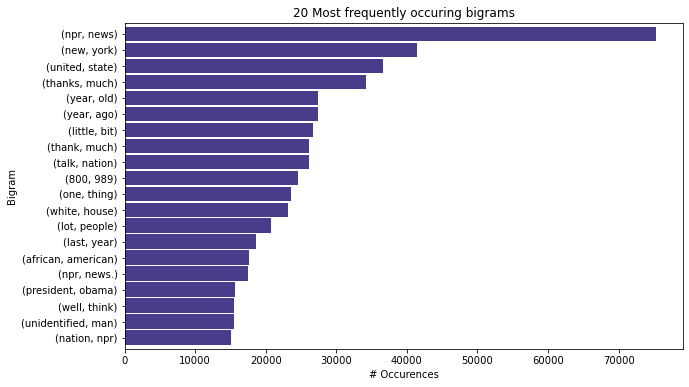

In [211]:
bigram.sort_values().plot.barh(color = 'darkslateblue', width = .9, figsize = (10, 6))

plt.title('20 Most frequently occuring bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')


In [177]:
trigram = pd.Series(nltk.ngrams(all_words.split(), 3)).value_counts().head(20)
trigram

(talk, nation, npr)             14999
(800, 989, 8255.)               13791
(nation, npr, news)             10662
(new, york, time)                8288
(989, 8255., email)              8033
(npr, news, thing)               7366
(listening, talk, nation)        7024
(edition, npr, news.)            6996
(morning, edition, npr)          6800
(news, thing, considered.)       6721
(npr, news, washington)          6546
(800, 989, 8255)                 6525
(8255., email, talknpr.org.)     6257
(thing, considered, npr)         5912
(talk, nation., neal)            5175
(nation., neal, conan)           5006
(thanks, much, thank)            4961
(new, york, city)                4884
(number, 800, 989)               4742
(thanks, much, call)             4662
dtype: int64

Text(0.5, 0, '# Occurences')

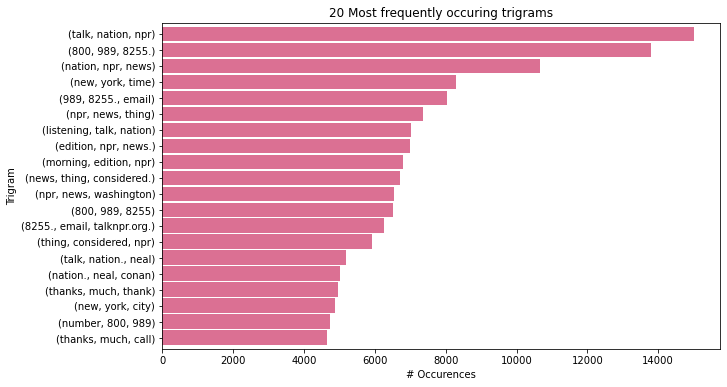

In [210]:
trigram.sort_values().plot.barh(color = 'palevioletred', width = .9, figsize = (10, 6))

plt.title('20 Most frequently occuring trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurences')


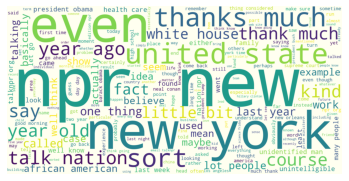

In [218]:
#img = WordCloud(background_color = 'ivory', width = 1600, height = 800).generate(all_words)
plt.imshow(img)
plt.axis('off');

In [230]:
all_words = ' '.join(df.e_stopwords)

In [231]:
all_freq = pd.Series(all_words.split()).value_counts()

In [235]:
all_freq_df.head(20)

,wrd,cnt
0,know,508552
1,people,402499
2,think,383573
3,say,374778
4,one,352654
5,ha,334667
6,like,327216
7,well,293128
8,going,285709
9,would,255551


In [236]:
all_freq_df = all_freq.to_frame().reset_index()
all_freq_df.columns = ['wrd', 'cnt']
all_freq_df

,wrd,cnt
0,know,508552
1,people,402499
2,think,383573
3,say,374778
4,one,352654
...,...,...
309774,dastaars,1
309775,flyrights.,1
309776,cybersurveillance,1
309777,reinsurers.,1


In [237]:
all_freq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309779 entries, 0 to 309778
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   wrd     309779 non-null  object
 1   cnt     309779 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.7+ MB


In [238]:
type(stop_words)

list

In [239]:
stop_words = []

for word in all_freq_df.wrd:
    if len(word) < 3:
        stop_words.append(word)

In [240]:
stop_words

['ha',
 'go',
 'oh',
 'hi',
 'ok',
 'tv',
 'ad',
 'la',
 'cd',
 'dj',
 'ak',
 'uk',
 'iq',
 'ip',
 'oz',
 'pi',
 'bi',
 'eh',
 'ac',
 'hd',
 'ox',
 'ow',
 'ga',
 'ep',
 'ew',
 'oc',
 'hq',
 'pu',
 'ey',
 'og']

In [6]:
df.head()

,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,date
episode_id,,,,,,,,,,
57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,False,it s a 2200 mile race. to give some sense of p...,2200 mile race. give sense perspective roughly...,0.0000,2010-07-12
57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,False,so for a top competitor like lance to try to m...,top competitor like lance try make much time 1...,0.9313,2010-07-12
57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,True,so in every team presumably there s one star o...,every team presumably one star one equivalent ...,0.7096,2010-07-12
57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,False,that s right. each team has nine riders. and w...,right. team ha nine riders. basically team lea...,0.9274,2010-07-12
57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,True,so slipstream this is like drafting in car rac...,slipstream like drafting car racing right ?,0.3612,2010-07-12


In [17]:
df.clean

episode_id
57264    it s a 2200 mile race. to give some sense of p...
57264    so for a top competitor like lance to try to m...
57264    so in every team presumably there s one star o...
57264    that s right. each team has nine riders. and w...
57264    so slipstream this is like drafting in car rac...
                               ...                        
69759                                           laughter .
69759                    it sounds like very good advice .
69759                         oh i don t know about that .
69759    ray magliozzi co host of the longtime npr prog...
69759         nice to talk to you too robert my pleasure .
Name: clean, Length: 2998347, dtype: object

In [22]:
df.isnull().sum()

episode_order           0
speaker                 0
utterance               0
program                 0
title                   0
is_host                 0
clean                   3
lemmatized_stopped    134
vader_stopped           0
date                    0
dtype: int64

In [25]:
df.dropna(inplace = True)

In [26]:
df.isnull().sum()

episode_order         0
speaker               0
utterance             0
program               0
title                 0
is_host               0
clean                 0
lemmatized_stopped    0
vader_stopped         0
date                  0
dtype: int64

In [11]:
all_words = ' '.join(u_df.clean)

In [12]:
all_freq = pd.Series(all_words.split()).value_counts()

In [13]:
type(all_freq)

pandas.core.series.Series

In [14]:
len(all_freq)

257841

In [15]:
#all freq before stopwords
all_freq_bsw = all_freq.copy()


In [16]:
all_freq_df = all_freq.to_frame().reset_index()
all_freq_df.columns = ['wrd', 'cnt']
all_freq_df

,wrd,cnt
0,",",4276113
1,the,3355366
2,and,1951823
3,to,1865784
4,of,1685712
...,...,...
257836,corel,1
257837,proph.,1
257838,saas.,1
257839,pagemaker.,1


In [17]:
stopword_list = stopwords.words('english')
stopword_list.sort()
stopword_list

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [18]:
stop_words = []

for word in all_freq_df.wrd:
    if len(word) < 3:
        stop_words.append(word)
        
stop_words.sort()
stop_words

['!',
 ',',
 ',,',
 '.',
 '..',
 '.1',
 '.2',
 '.3',
 '.4',
 '.5',
 '.6',
 '.7',
 '.8',
 '.9',
 '.i',
 '0',
 '0.',
 '00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '0f',
 '0h',
 '0s',
 '1',
 '1.',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '1a',
 '1b',
 '1e',
 '1l',
 '1o',
 '1s',
 '2',
 '2.',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '2a',
 '2b',
 '2c',
 '2d',
 '2f',
 '2g',
 '2s',
 '2x',
 '3',
 '3.',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '3a',
 '3b',
 '3c',
 '3d',
 '3g',
 '3m',
 '3q',
 '3s',
 '3x',
 '4',
 '4.',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '4a',
 '4b',
 '4c',
 '4g',
 '4h',
 '4k',
 '4o',
 '4r',
 '4s',
 '4w',
 '4x',
 '5',
 '5.',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '5a',
 '5c',
 '5d',
 '5g',
 '5h',
 '5k',
 '5o',
 '5s',
 '5x',
 '6',
 '6.',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '

In [19]:
len(stop_words)

861

In [44]:
# list of words to keep
back_stop_words = ['!', '.', '..', '?', 'ak','al','am', 'ap', 'ar', 'ax', 'ay', 'co', 'ct',
                  'eh', 'ew', 'ez', 'ha', 'hi', 'ie', 'ip', 'ko', 'no', 'ok', 'q1', 'q2', 
                  'q3', 'q4', 'tv', 'tx', 'uk', ]

In [45]:
for word in back_stop_words:
    stop_words.remove(word)

In [46]:
df['e_stopwords'] = [remove_stopwords(u, extra_words = stop_words) for u in df.lemmatized_stopped]

In [47]:
all_words = ' '.join(df.e_stopwords)

In [48]:
all_freq = pd.Series(all_words.split()).value_counts()

In [56]:
all_freq.head(45)

.            2496039
?             568481
know          508552
people        402499
think         383573
say           374778
one           352654
ha            334667
like          327216
well          293128
going         285709
would         255551
get           249207
year          242715
really        217372
time          215861
thing         206089
new           192982
much          183509
right         180707
lot           179674
npr           170957
want          160986
also          158621
said          156484
way           153721
...           153419
mean          152857
see           147874
president     145510
make          143299
back          141504
state         140683
could         136938
kind          136849
first         131429
many          130887
come          125245
good          123932
two           123892
day           122542
even          120225
news          118631
talk          117355
got           115335
dtype: int64

In [52]:
bigram = pd.Series(nltk.ngrams(all_words.split(), 2)).value_counts().head(20)
bigram

(?, well)          88404
(., well)          76535
(npr, news)        75284
(., thank)         55920
(thank, .)         42924
(., npr)           42116
(., think)         41686
(new, york)        41421
(., know)          36685
(united, state)    36580
(news, .)          35986
(thanks, much)     34227
(., yeah)          33594
(., let)           29798
(much, .)          29399
(year, old)        27461
(year, ago)        27430
(right, .)         26834
(little, bit)      26763
(., ...)           26182
dtype: int64

In [54]:
len(stop_words)

915

In [61]:
stop_words_df = pd.DataFrame(stop_words)

In [65]:
stop_words_df.reset_index
stop_words_df#.columns = 'word'

,0
0,.1
1,.2
2,.3
3,.4
4,.5
...,...
910,zo
911,zs
912,zu
913,zy


In [71]:
stop_words_df.rename(columns = {'0': 'words'}, inplace = True)
stop_words_df.columns = ['words']
stop_words_df.columns

Index(['words'], dtype='object')

In [76]:
stop_words_df.to_excel('/Users/davidrodriguez/codeup-data-science/npr-nlp-project/stop_words_df.xlsx')

In [74]:
pwd

'/Users/davidrodriguez/codeup-data-science/npr-nlp-project'

In [118]:
df[df.speaker.str.contains('neal conan')].speaker

2          neal conan, host
4          neal conan, host
6          neal conan, host
8          neal conan, host
10         neal conan, host
                 ...       
2997998    neal conan, host
2998001    neal conan, host
2998003    neal conan, host
2998005    neal conan, host
2998007    neal conan, host
Name: speaker, Length: 256295, dtype: object

In [119]:
#df.reset_index(inplace = True)
#df.drop(columns = ['level_0', 'index'], inplace = True)
df.speaker = df.speaker.str.lower()
top_speakers = df[df.is_host == True].groupby('speaker').episode_id.count().to_frame().sort_values(by = 'episode_id', ascending = False).head(10).index


In [123]:
top_sp_df = df[df.speaker.isin(top_speakers)]
top_sp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626034 entries, 2 to 2998211
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   episode_id          626034 non-null  int64         
 1   episode_order       626034 non-null  int64         
 2   speaker             626034 non-null  object        
 3   utterance           626034 non-null  object        
 4   program             626034 non-null  object        
 5   title               626034 non-null  object        
 6   is_host             626034 non-null  bool          
 7   clean               626034 non-null  object        
 8   lemmatized_stopped  626034 non-null  object        
 9   vader_stopped       626034 non-null  float64       
 10  date                626034 non-null  datetime64[ns]
 11  e_stopwords         626034 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 57.9+ MB

In [125]:
top_sp_df.set_index('date', inplace = True)
top_sp_df

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,e_stopwords
date,,,,,,,,,,,
2010-07-12,57264,11,"neal conan, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,True,so in every team presumably there s one star o...,every team presumably one star one equivalent ...,0.7096,every team presumably one star one equivalent ...
2010-07-12,57264,13,"neal conan, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,True,so slipstream this is like drafting in car rac...,slipstream like drafting car racing right ?,0.3612,slipstream like drafting car racing right ?
2010-07-12,57264,15,"neal conan, host",And so the guy who's in back has an easier tim...,Talk of the Nation,How To Watch The Tour De France,True,and so the guy who s in back has an easier tim...,guy back ha easier time. even people front bre...,0.6369,guy back ha easier time. even people front bre...
2010-07-12,57264,17,"neal conan, host","We're talking with Loren Mooney, the editor-in...",Talk of the Nation,How To Watch The Tour De France,True,we re talking with loren mooney the editor in ...,talking loren mooney editor chief bicycling ma...,0.0772,talking loren mooney editor chief bicycling ma...
2010-07-12,57264,19,"neal conan, host","Hi, John.",Talk of the Nation,How To Watch The Tour De France,True,hi john .,hi john .,0.0000,hi john .
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-29,69759,23,"robert siegel, host",...That we might have this time of year or any...,All Things Considered,Should You Warm Up Your Car Before Driving To ...,False,... that we might have this time of year or an...,... might time year time year matter .,0.0258,... might time year time year matter .
2017-12-29,69759,25,"robert siegel, host",(Laughter).,All Things Considered,Should You Warm Up Your Car Before Driving To ...,False,laughter .,laughter .,0.4939,laughter .
2017-12-29,69759,28,"robert siegel, host","Well (laughter), I'm not sure if that's news o...",All Things Considered,Should You Warm Up Your Car Before Driving To ...,False,well laughter i m not sure if that s news one ...,well laughter sure news one use. ...,0.7650,well laughter sure news one use. ...


In [2]:
u_df = pd.read_csv('npr_corpus.csv', index_col = 0)
u_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1889857 entries, 0 to 3199856
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   episode_id     int64  
 1   episode_order  int64  
 2   speaker        object 
 3   utterance      object 
 4   program        object 
 5   title          object 
 6   episode_date   object 
 7   is_host        bool   
 8   clean          object 
 9   lemmatized     object 
 10  vader          float64
 11  date           object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 174.8+ MB


In [180]:
u_df.speaker.nunique()

115988

In [181]:
u_df.date = pd.to_datetime(u_df.date)
u_df = u_df.set_index('date').sort_index()
u_df

,episode_id,episode_order,speaker,utterance,program,title,episode_date,is_host,clean,lemmatized,vader
date,,,,,,,,,,,
2005-01-11,84432,85,"neal conan, host",OK.,talk of the nation,difference between a think and a 'blink',2005-01-11,True,ok .,ok .,0.2960
2005-01-11,84432,29,"mr. malcolm gladwell (author, ""blink"")",Yes.,talk of the nation,difference between a think and a 'blink',2005-01-11,False,yes .,yes .,0.4019
2005-01-11,84432,30,gabriel (caller),...the differences were taken for essence. I'...,talk of the nation,difference between a think and a 'blink',2005-01-11,False,... the differences were taken for essence. i ...,... the difference were taken for essence. i l...,0.0000
2005-01-11,84432,31,"neal conan, host","OK, thanks for the call, Gabriel. Thanks.",talk of the nation,difference between a think and a 'blink',2005-01-11,True,"ok , thanks for the call , gabriel. thanks .","ok , thanks for the call , gabriel. thanks .",0.7906
2005-01-11,84432,32,"mr. malcolm gladwell (author, ""blink"")",I think that's a really interesting and import...,talk of the nation,difference between a think and a 'blink',2005-01-11,False,i think that s a really interesting and import...,i think that s a really interesting and import...,-0.8548
...,...,...,...,...,...,...,...,...,...,...,...
2019-10-12,716,25,"greg allen, byline",That's because the census is used to determine...,weekend edition saturday,"panama city, fla., struggles to recover a year...",2019-10-12,False,that s because the census is used to determine...,that s because the census is used to determine...,0.5719
2019-10-12,716,24,mark mcqueen,That four-hour-named storm called Hurricane Mi...,weekend edition saturday,"panama city, fla., struggles to recover a year...",2019-10-12,False,that four hour named storm called hurricane mi...,that four hour named storm called hurricane mi...,-0.5106
2019-10-12,713,15,"ron elving, byline",Thank you Scott.,weekend edition saturday,week in politics,2019-10-12,False,thank you scott .,thank you scott .,0.3612


In [134]:
u_df.resample('M').vader_stopped.mean()

date
1999-01-31    0.422604
1999-02-28         NaN
1999-03-31         NaN
1999-04-30         NaN
1999-05-31         NaN
                ...   
2019-06-30    0.203865
2019-07-31    0.176255
2019-08-31    0.154648
2019-09-30    0.191395
2019-10-31    0.180004
Freq: M, Name: vader_stopped, Length: 250, dtype: float64

In [3]:
u_df.isnull().sum()

episode_id       0
episode_order    0
speaker          4
utterance        0
program          0
title            0
episode_date     0
is_host          0
clean            2
lemmatized       2
vader            0
date             0
dtype: int64

In [4]:
u_df.dropna(inplace = True)

In [186]:
all_words = ' '.join(u_df.clean)

In [187]:
all_freq = pd.Series(all_words.split()).value_counts()

In [188]:
all_freq_df = all_freq.to_frame().reset_index()
all_freq_df.columns = ['wrd', 'cnt']
all_freq_df

,wrd,cnt
0,",",4276113
1,the,3355366
2,and,1951823
3,to,1865784
4,of,1685712
...,...,...
257836,nenets.,1
257837,queasier.,1
257838,queasier,1
257839,rolph,1


In [189]:
for word in all_freq_df.wrd:
    if len(word) < 3:
        stop_words.append(word)
        
stop_words.sort()
stop_words

['!',
 ',',
 ',,',
 '.',
 '..',
 '.1',
 '.1',
 '.1',
 '.1',
 '.2',
 '.2',
 '.2',
 '.2',
 '.3',
 '.3',
 '.3',
 '.3',
 '.4',
 '.4',
 '.4',
 '.4',
 '.5',
 '.5',
 '.5',
 '.5',
 '.6',
 '.6',
 '.6',
 '.6',
 '.7',
 '.7',
 '.7',
 '.7',
 '.8',
 '.8',
 '.8',
 '.8',
 '.9',
 '.9',
 '.9',
 '.9',
 '.i',
 '.o',
 '.o',
 '.o',
 '0',
 '0',
 '0',
 '0',
 '0.',
 '0.',
 '0.',
 '0.',
 '00',
 '00',
 '00',
 '00',
 '01',
 '01',
 '01',
 '01',
 '02',
 '02',
 '02',
 '02',
 '03',
 '03',
 '03',
 '03',
 '04',
 '04',
 '04',
 '04',
 '05',
 '05',
 '05',
 '05',
 '06',
 '06',
 '06',
 '06',
 '07',
 '07',
 '07',
 '07',
 '08',
 '08',
 '08',
 '08',
 '09',
 '09',
 '09',
 '09',
 '0f',
 '0f',
 '0f',
 '0f',
 '0h',
 '0h',
 '0h',
 '0h',
 '0s',
 '0s',
 '0s',
 '0s',
 '1',
 '1',
 '1',
 '1',
 '1.',
 '1.',
 '1.',
 '1.',
 '10',
 '10',
 '10',
 '10',
 '11',
 '11',
 '11',
 '11',
 '12',
 '12',
 '12',
 '12',
 '13',
 '13',
 '13',
 '13',
 '14',
 '14',
 '14',
 '14',
 '15',
 '15',
 '15',
 '15',
 '16',
 '16',
 '16',
 '16',
 '17',
 '17',
 '17',
 '1

In [190]:
# list of words to keep
back_stop_words = ['!', '.', '..', '?', 'ak','al','am', 'ap', 'ar', 'ax', 'ay', 'co', 'ct',
                  'eh', 'ew', 'ez', 'ha', 'hi', 'ie', 'ip', 'ko', 'no', 'ok', 'q1', 'q2', 
                  'q3', 'q4', 'tv', 'tx', 'uk', ]

In [192]:
for word in back_stop_words:
    stop_words.remove(word)

ValueError: list.remove(x): x not in list

In [153]:
stop_words

['.1',
 '.1',
 '.1',
 '.2',
 '.2',
 '.2',
 '.3',
 '.3',
 '.3',
 '.4',
 '.4',
 '.4',
 '.5',
 '.5',
 '.5',
 '.6',
 '.6',
 '.6',
 '.7',
 '.7',
 '.7',
 '.8',
 '.8',
 '.8',
 '.9',
 '.9',
 '.9',
 '.o',
 '.o',
 '.o',
 '0',
 '0',
 '0',
 '0.',
 '0.',
 '0.',
 '00',
 '00',
 '00',
 '01',
 '01',
 '01',
 '02',
 '02',
 '02',
 '03',
 '03',
 '03',
 '04',
 '04',
 '04',
 '05',
 '05',
 '05',
 '06',
 '06',
 '06',
 '07',
 '07',
 '07',
 '08',
 '08',
 '08',
 '09',
 '09',
 '09',
 '0f',
 '0f',
 '0f',
 '0h',
 '0h',
 '0h',
 '0s',
 '0s',
 '0s',
 '1',
 '1',
 '1',
 '1.',
 '1.',
 '1.',
 '10',
 '10',
 '10',
 '11',
 '11',
 '11',
 '12',
 '12',
 '12',
 '13',
 '13',
 '13',
 '14',
 '14',
 '14',
 '15',
 '15',
 '15',
 '16',
 '16',
 '16',
 '17',
 '17',
 '17',
 '18',
 '18',
 '18',
 '19',
 '19',
 '19',
 '1a',
 '1a',
 '1a',
 '1b',
 '1b',
 '1b',
 '1c',
 '1c',
 '1c',
 '1e',
 '1e',
 '1e',
 '1l',
 '1l',
 '1l',
 '1o',
 '1o',
 '1o',
 '1s',
 '1s',
 '1s',
 '2',
 '2',
 '2',
 '2.',
 '2.',
 '2.',
 '20',
 '20',
 '20',
 '21',
 '21',
 '21',
 

In [94]:
stop_words_df = pd.DataFrame(stop_words)

In [95]:
stop_words_df.rename(columns = {'0': 'words'}, inplace = True)
stop_words_df.columns = ['words']
stop_words_df.columns

Index(['words'], dtype='object')

In [96]:
stop_words_df.to_excel('/Users/davidrodriguez/codeup-data-science/npr-nlp-project/stop_words_df.xlsx')

In [207]:
u_df.reset_index(inplace = True)

In [8]:
u_df['year'] = pd.DatetimeIndex(u_df['date']).year

In [97]:
u_df['clean_stopped'] = [remove_stopwords(u, extra_words = stop_words) for u in u_df.clean]

In [98]:
words_2007 = ' '.join(u_df[u_df.year == 2007].clean_stopped)
words_2006 = ' '.join(u_df[u_df.year == 2006].clean_stopped)
words_2008 = ' '.join(u_df[u_df.year == 2008].clean_stopped)
words_2009 = ' '.join(u_df[u_df.year == 2009].clean_stopped)
words_2010 = ' '.join(u_df[u_df.year == 2010].clean_stopped)
words_2011 = ' '.join(u_df[u_df.year == 2011].clean_stopped)
words_2012 = ' '.join(u_df[u_df.year == 2012].clean_stopped)
words_2005 = ' '.join(u_df[u_df.year == 2005].clean_stopped)
words_2013 = ' '.join(u_df[u_df.year == 2013].clean_stopped)
words_2018 = ' '.join(u_df[u_df.year == 2018].clean_stopped)
words_2017 = ' '.join(u_df[u_df.year == 2017].clean_stopped)
words_2016 = ' '.join(u_df[u_df.year == 2016].clean_stopped)
words_2014 = ' '.join(u_df[u_df.year == 2014].clean_stopped)
words_2015 = ' '.join(u_df[u_df.year == 2015].clean_stopped)
words_2019 = ' '.join(u_df[u_df.year == 2019].clean_stopped)
words_2004 = ' '.join(u_df[u_df.year == 2004].clean_stopped)
words_1999 = ' '.join(u_df[u_df.year == 1999].clean_stopped)

In [99]:
all_words = ' '.join(u_df.clean_stopped)

In [100]:
freq_2007 = pd.Series(words_2007.split()).value_counts()
freq_2006 = pd.Series(words_2006.split()).value_counts()
freq_2008 = pd.Series(words_2008.split()).value_counts()
freq_2009 = pd.Series(words_2009.split()).value_counts()
freq_2010 = pd.Series(words_2010.split()).value_counts()
freq_2011 = pd.Series(words_2011.split()).value_counts()
freq_2012 = pd.Series(words_2012.split()).value_counts()
freq_2005 = pd.Series(words_2005.split()).value_counts()
freq_2013 = pd.Series(words_2013.split()).value_counts()
freq_2018 = pd.Series(words_2018.split()).value_counts()
freq_2017 = pd.Series(words_2017.split()).value_counts()
freq_2016 = pd.Series(words_2016.split()).value_counts()
freq_2014 = pd.Series(words_2014.split()).value_counts()
freq_2015 = pd.Series(words_2015.split()).value_counts()
freq_2019 = pd.Series(words_2019.split()).value_counts()
freq_2004 = pd.Series(words_2004.split()).value_counts()
freq_1999 = pd.Series(words_1999.split()).value_counts()

In [101]:
all_freq = pd.Series(all_words.split()).value_counts()

In [102]:
word_counts = (pd.concat([all_freq, freq_2007, freq_2006, freq_2008, freq_2009, freq_2010,
                         freq_2011, freq_2012, freq_2005, freq_2013, freq_2018, freq_2017,
                         freq_2016, freq_2014, freq_2015, freq_2019, freq_2004, freq_1999], axis = 1, sort = True)
               .set_axis(['all', '2007', '2006', '2008', '2009', '2010', '2011', '2012',
                         '2005', '2013', '2018', '2017', '2016', '2014', '2015', '2019', '2004', '1999'], 
                         axis = 1, inplace = False)
               .fillna(0)
               .apply(lambda s: s.astype(int)))

In [103]:
word_counts.head(5)

,all,2007,2006,2008,2009,2010,2011,2012,2005,2013,2018,2017,2016,2014,2015,2019,2004,1999
&#9;,28,3,0,3,0,0,1,2,0,3,0,1,10,5,0,0,0,0
",,,",1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
",1048",1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
",12",1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
",40",1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Proportion of Words by Year For the Most 20 Common Words')

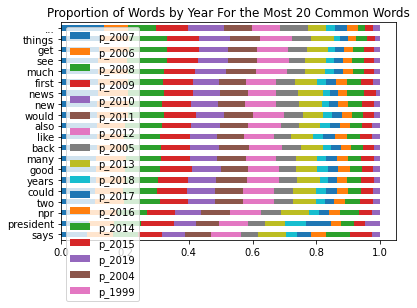

In [104]:
(word_counts
 .assign(p_2007 = word_counts['2007'] / word_counts['all'],
         p_2006 = word_counts['2006'] / word_counts['all'],
         p_2008 = word_counts['2008'] / word_counts['all'],
         p_2009 = word_counts['2009'] / word_counts['all'],
         p_2010 = word_counts['2010'] / word_counts['all'],
         p_2011 = word_counts['2011'] / word_counts['all'],
         p_2012 = word_counts['2012'] / word_counts['all'],
         p_2005 = word_counts['2005'] / word_counts['all'],
         p_2013 = word_counts['2013'] / word_counts['all'],
         p_2018 = word_counts['2018'] / word_counts['all'],
         p_2017 = word_counts['2017'] / word_counts['all'],
         p_2016 = word_counts['2016'] / word_counts['all'],
         p_2014 = word_counts['2014'] / word_counts['all'],
         p_2015 = word_counts['2015'] / word_counts['all'],
         p_2019 = word_counts['2019'] / word_counts['all'],
         p_2004 = word_counts['2004'] / word_counts['all'],
         p_1999 = word_counts['1999'] / word_counts['all']
        )
 .sort_values(by = 'all')
 [['p_2007', 'p_2006', 'p_2008', 'p_2009', 'p_2010', 'p_2011', 'p_2012', 'p_2005',
  'p_2013', 'p_2018', 'p_2017', 'p_2016', 'p_2014', 'p_2015', 'p_2019', 'p_2004', 'p_1999']]
 .tail(20)
 .sort_values('p_2007')
 .plot.barh(stacked = True))

plt.title('Proportion of Words by Year For the Most 20 Common Words')

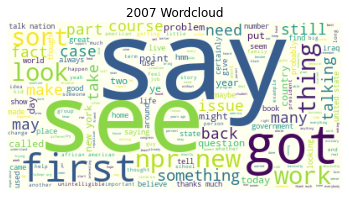

In [105]:
img_2007 = WordCloud(background_color = 'ivory').generate(words_2007)
plt.imshow(img_2007)
plt.axis('off')
plt.title('2007 Wordcloud');

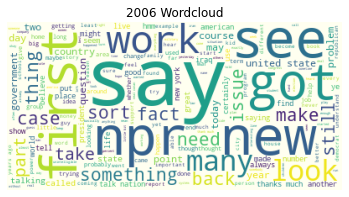

In [106]:
img_2006 = WordCloud(background_color = 'ivory').generate(words_2006)
plt.imshow(img_2006)
plt.axis('off')
plt.title('2006 Wordcloud');

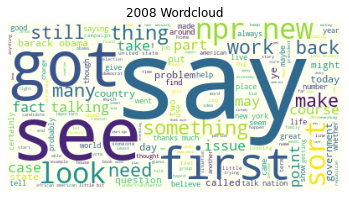

In [107]:
img_2008 = WordCloud(background_color = 'ivory').generate(words_2008)
plt.imshow(img_2008)
plt.axis('off')
plt.title('2008 Wordcloud');

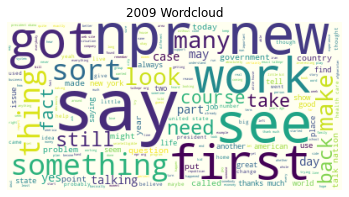

In [108]:
img_2009 = WordCloud(background_color = 'ivory').generate(words_2009)
plt.imshow(img_2009)
plt.axis('off')
plt.title('2009 Wordcloud');

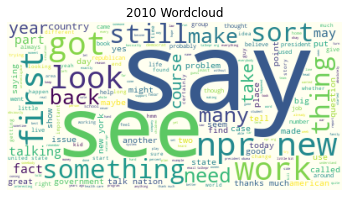

In [109]:
img_2010 = WordCloud(background_color = 'ivory').generate(words_2010)
plt.imshow(img_2010)
plt.axis('off')
plt.title('2010 Wordcloud');

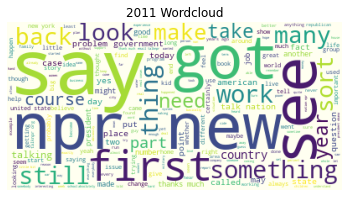

In [110]:
img_2011 = WordCloud(background_color = 'ivory').generate(words_2011)
plt.imshow(img_2011)
plt.axis('off')
plt.title('2011 Wordcloud');

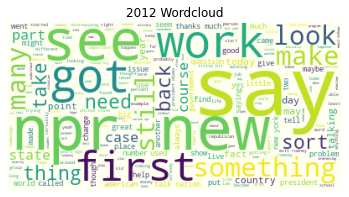

In [111]:
img_2012 = WordCloud(background_color = 'ivory').generate(words_2012)
plt.imshow(img_2012)
plt.axis('off')
plt.title('2012 Wordcloud');

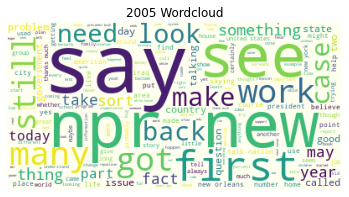

In [112]:
img_2005 = WordCloud(background_color = 'ivory').generate(words_2005)
plt.imshow(img_2005)
plt.axis('off')
plt.title('2005 Wordcloud');

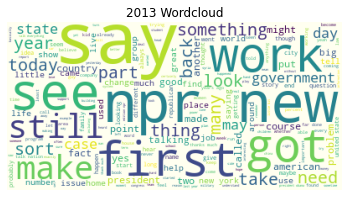

In [113]:
img_2013 = WordCloud(background_color = 'ivory').generate(words_2013)
plt.imshow(img_2013)
plt.axis('off')
plt.title('2013 Wordcloud');

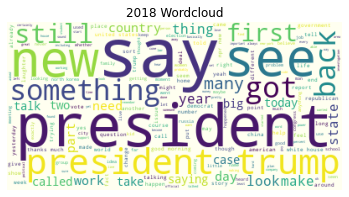

In [114]:
img_2018 = WordCloud(background_color = 'ivory').generate(words_2018)
plt.imshow(img_2018)
plt.axis('off')
plt.title('2018 Wordcloud');

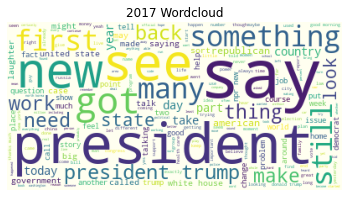

In [115]:
img_2017 = WordCloud(background_color = 'ivory').generate(words_2017)
plt.imshow(img_2017)
plt.axis('off')
plt.title('2017 Wordcloud');

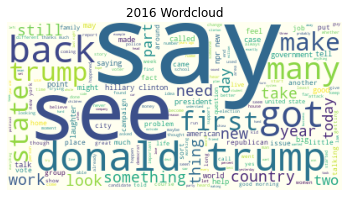

In [116]:
img_2016 = WordCloud(background_color = 'ivory').generate(words_2016)
plt.imshow(img_2016)
plt.axis('off')
plt.title('2016 Wordcloud');

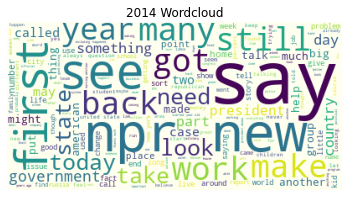

In [117]:
img_2014 = WordCloud(background_color = 'ivory').generate(words_2014)
plt.imshow(img_2014)
plt.axis('off')
plt.title('2014 Wordcloud');

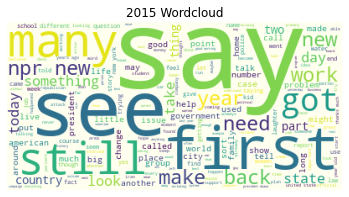

In [118]:
img_2015 = WordCloud(background_color = 'ivory').generate(words_2015)
plt.imshow(img_2015)
plt.axis('off')
plt.title('2015 Wordcloud');

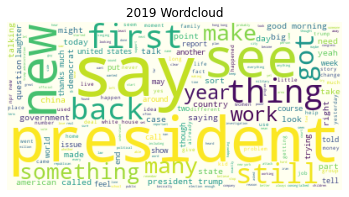

In [119]:
img_2019 = WordCloud(background_color = 'ivory').generate(words_2019)
plt.imshow(img_2019)
plt.axis('off')
plt.title('2019 Wordcloud');

In [89]:
#img_2004 = WordCloud(background_color = 'ivory').generate(words_2004)
#plt.imshow(img_2004)
#plt.axis('off')
#plt.title('2004 Wordcloud');

In [90]:
#img_1999 = WordCloud(background_color = 'ivory').generate(words_1999)
#plt.imshow(img_1999)
#plt.axis('off')
#plt.title('1999 Wordcloud');

In [123]:
addtl_stopwords = ['say', 'people', 'one', 'know', 'going', 'well', 'think', 'said', 'time',
                  'kind', 'way', 'right', 'mean', 'thing', 'really', 'lot', 'say', 'actually',
                  'thing', 'even', 'want', 'yeah', 'come', 'see', 'first', 'things']

In [124]:
for w in addtl_stopwords:
    stop_words.append(w)

In [125]:
stop_words

['!',
 ',',
 ',,',
 '.',
 '..',
 '.1',
 '.2',
 '.3',
 '.4',
 '.5',
 '.6',
 '.7',
 '.8',
 '.9',
 '.i',
 '0',
 '0.',
 '00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '0f',
 '0h',
 '0s',
 '1',
 '1.',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '1a',
 '1b',
 '1e',
 '1l',
 '1o',
 '1s',
 '2',
 '2.',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '2a',
 '2b',
 '2c',
 '2d',
 '2f',
 '2g',
 '2s',
 '2x',
 '3',
 '3.',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '3a',
 '3b',
 '3c',
 '3d',
 '3g',
 '3m',
 '3q',
 '3s',
 '3x',
 '4',
 '4.',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '4a',
 '4b',
 '4c',
 '4g',
 '4h',
 '4k',
 '4o',
 '4r',
 '4s',
 '4w',
 '4x',
 '5',
 '5.',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '5a',
 '5c',
 '5d',
 '5g',
 '5h',
 '5k',
 '5o',
 '5s',
 '5x',
 '6',
 '6.',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '